In [1]:
# For division
from __future__ import division

#Let's go ahead and start with some imports
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

In [2]:
end = datetime.now()
start = datetime(end.year- 1, end.month, end.day)

stock_list = ['AMZN','BABA']

for stock in stock_list:
    globals()[stock] = DataReader(stock,'yahoo',start,end)

# 1. How are the two stocks related?
# 2. How is the risk of each stock?


In [3]:
BABA.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-05,157.229996,151.850006,155.029999,153.669998,28912600,153.669998
2019-08-06,158.729996,156.110001,158.479996,157.429993,24996300,157.429993
2019-08-07,159.479996,155.300003,155.729996,159.169998,17917400,159.169998
2019-08-08,162.300003,159.119995,161.710007,162.220001,19267700,162.220001
2019-08-09,161.990005,159.110001,160.979996,159.119995,11894300,159.119995


Calculate the moving average of the stock

In [4]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    BABA[column_name]=BABA['Adj Close'].rolling(ma).mean()

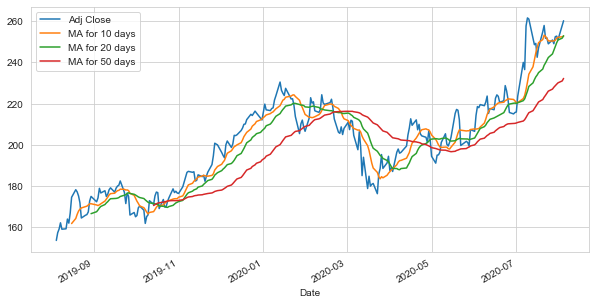

In [5]:
BABA[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(subplots=False,figsize=(10,5))

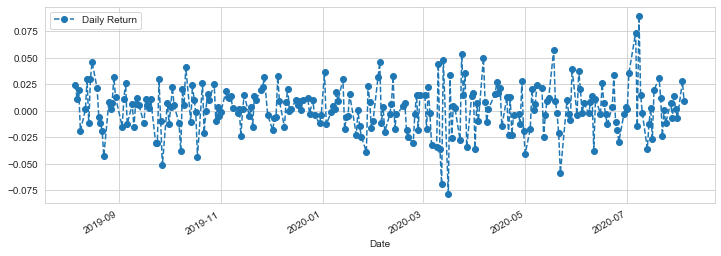

In [6]:
# Use pct_change to find the percent change for each day
BABA['Daily Return'] = BABA['Adj Close'].pct_change()
# Then plot the daily return percentage
BABA['Daily Return'].plot(figsize=(12,4),legend=True,linestyle ='--',marker='o')


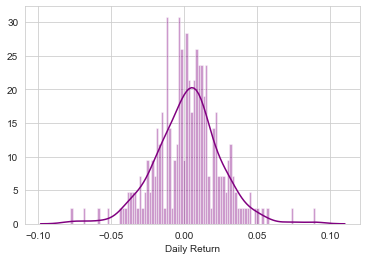

In [7]:
sns.distplot(BABA['Daily Return'].dropna(),bins = 100, color = 'purple')

In [8]:
closing_df = DataReader(stock_list,'yahoo',start,end)['Adj Close']
closing_df.head()

Symbols,AMZN,BABA
Date,,
2019-08-05,1765.130005,153.669998
2019-08-06,1787.829956,157.429993
2019-08-07,1793.400024,159.169998
2019-08-08,1832.890015,162.220001
2019-08-09,1807.579956,159.119995


In [9]:
ecomm_rets = closing_df.pct_change()
ecomm_rets.head()

Symbols,AMZN,BABA
Date,,
2019-08-05,NaN,NaN
2019-08-06,0.012860,0.024468
2019-08-07,0.003116,0.011053
2019-08-08,0.022020,0.019162
2019-08-09,-0.013809,-0.019110


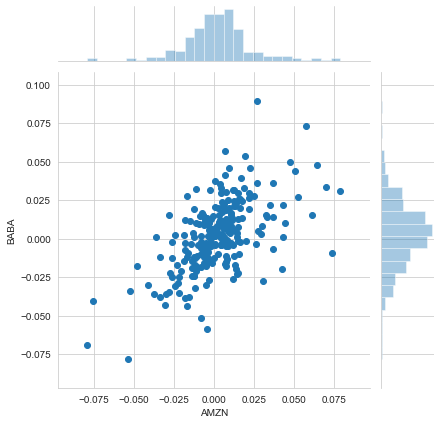

In [10]:
#Visualization of two stocks on jointplot

sns.jointplot('AMZN','BABA',ecomm_rets,kind='scatter')

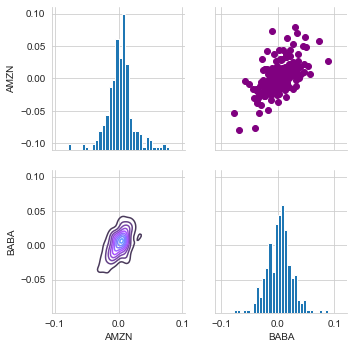

In [11]:
# Set up figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(ecomm_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# Specify the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

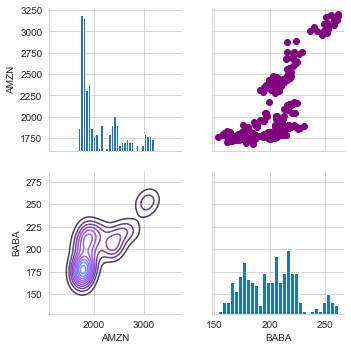

In [12]:
# Set up figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# Specify the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally define the diagonal as a series of histogram plots of the closing price
returns_fig.map_diag(plt.hist,bins=30)

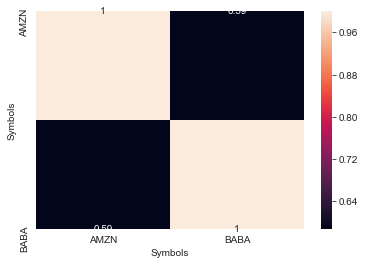

In [13]:
sns.heatmap(ecomm_rets.corr().dropna(),annot=True)


# The two stocks have a weak positive correlation.

AMZN 0.0024976368957187337 0.021193932556378556
BABA 0.0023400564933313086 0.02232889174756418


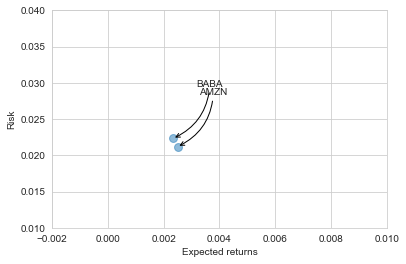

In [14]:
# Define a new DataFrame as a clenaed version of the oriignal ecomm_rets DataFrame
rets = ecomm_rets.dropna()

area = np.pi*20

#Mean represent the expected return value, standard deviation represent the risk
plt.scatter(rets.mean(), rets.std(),alpha = 0.5,s =area)

# Set the x and y limits of the plot
plt.ylim([0.01,0.04])
plt.xlim([-0.002,0.01])

#Set the plot axis titles
plt.xlabel('Expected returns')
plt.ylabel('Risk')

# Label the scatter plots, for more info on how this is done, chekc out the link below
# http://matplotlib.org/users/annotations_guide.html
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    print(label,x,y)
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=-0.3',color='black'))

In [15]:
print('Amazon: %s' % (rets['AMZN'].quantile(0.05)))
print('Alibaba: %s' % (rets['BABA'].quantile(0.05)))

#With 95% confidence level, at most one will lose such amount of money on respective stock

Amazon: -0.028128624803580866
Alibaba: -0.03496290787128439


The equation for geometric Browninan motion, or known as the Monte Carlo process is given by the following equation:

$$\frac{\Delta S}{S} = \mu\Delta t + \sigma \epsilon \sqrt{\Delta t}$$ 

Where S is the stock price, mu is the expected return (which we calculated earlier),sigma is the standard deviation of the returns, t is time, and epsilon is the random variable.

Mulitply both sides by the stock price (S) to rearrange the formula and solve for the stock price.

$$ \Delta S = S(\mu\Delta t + \sigma \epsilon \sqrt{\Delta t}) $$ 

In [16]:
def stock_monte_carlo(start_price,days,mu,sigma):
    ''' This function takes in starting stock price, days of simulation,mu,sigma, and returns simulated price array'''
    
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price
    # Shock and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # Run price array for number of days
    for x in range(1,days):
        
        # Calculate Schock
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        # Calculate Drift
        drift[x] = mu * dt
        # Calculate Price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

In [17]:
days = 365

dt = 1/days

mu = rets.mean()['BABA']

sigma = rets.std()['BABA']

BABA.head() #To get the start_price

,High,Low,Open,Close,Volume,Adj Close,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
Date,,,,,,,,,,
2019-08-05,157.229996,151.850006,155.029999,153.669998,28912600,153.669998,NaN,NaN,NaN,NaN
2019-08-06,158.729996,156.110001,158.479996,157.429993,24996300,157.429993,NaN,NaN,NaN,0.024468
2019-08-07,159.479996,155.300003,155.729996,159.169998,17917400,159.169998,NaN,NaN,NaN,0.011053
2019-08-08,162.300003,159.119995,161.710007,162.220001,19267700,162.220001,NaN,NaN,NaN,0.019162
2019-08-09,161.990005,159.110001,160.979996,159.119995,11894300,159.119995,NaN,NaN,NaN,-0.019110


Text(0.5, 1.0, 'Monte Carlo Analysis for Alibaba')

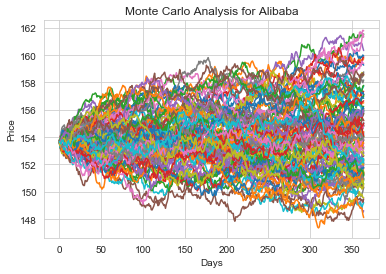

In [18]:
start_price_baba = 153.67

for run in range(100):
    plt.plot(stock_monte_carlo(start_price_baba,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Alibaba')

In [19]:
runs = 10000
simulations_baba = np.zeros(runs)
np.set_printoptions(threshold=5)

for run in range(runs):
    simulations_baba[run] = stock_monte_carlo(start_price_baba,days,mu,sigma)[days-1]

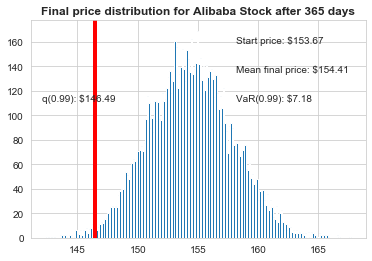

In [20]:
# Now we'lll define q as the 1% empirical qunatile, this basically means that 99% of the values should fall between here
q = np.percentile(simulations_baba, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations_baba,bins=200)

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price_baba)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations_baba.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price_baba - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title("Final price distribution for Alibaba Stock after %s days" % days, weight='bold');

In [21]:
days = 365

dt = 1/days

mu = rets.mean()['AMZN']

sigma = rets.std()['AMZN']

AMZN.head() #To get the start_price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-05,1788.670044,1748.780029,1770.219971,1765.130005,6058200,1765.130005
2019-08-06,1793.770020,1753.400024,1792.229980,1787.829956,5070300,1787.829956
2019-08-07,1798.930054,1757.000000,1773.989990,1793.400024,4526900,1793.400024
2019-08-08,1834.260010,1798.109985,1806.000000,1832.890015,3701200,1832.890015
2019-08-09,1831.089966,1802.219971,1828.949951,1807.579956,2879800,1807.579956


Text(0.5, 1.0, 'Monte Carlo Analysis for Amazon')

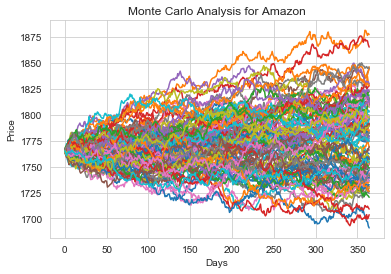

In [22]:
start_price_amzn = 1765.13

for run in range(100):
    plt.plot(stock_monte_carlo(start_price_amzn,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Amazon')

In [23]:
runs = 10000
simulations_amzn = np.zeros(runs)
np.printoptions(threshold = 5)

for run in range(runs):
    simulations_amzn[run] = stock_monte_carlo(start_price_amzn,days,mu,sigma)[days-1]

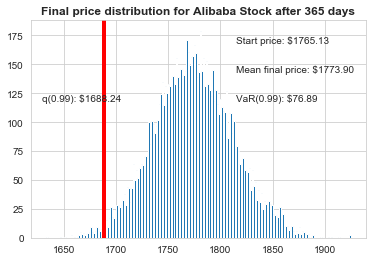

In [24]:
# Now we'lll define q as the 1% empirical qunatile, this basically means that 99% of the values should fall between here
q = np.percentile(simulations_amzn, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations_amzn,bins=200)

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price_amzn)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations_amzn.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price_amzn - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title("Final price distribution for Alibaba Stock after %s days" % days, weight='bold');

In [25]:
print('Alibaba has a risk of: %s' %(simulations_baba.std() / simulations_baba.mean()))
print('Amazon has a risk of: %s' %(simulations_amzn.std() / simulations_amzn.mean()))

Alibaba has a risk of: 0.022334808215510912
Amazon has a risk of: 0.02140878476995674


In [26]:
print('Alibaba has a return of: %s' %(simulations_baba.mean() / start_price_baba))
print('Amazon has a return of: %s' %(simulations_amzn.mean() / start_price_amzn))

Alibaba has a return of: 1.0048417406074694
Amazon has a return of: 1.0049675585866389



# While they have similar returns and risks, Amazon has a slight adavantage over Alibaba in both terms